# **LightGBM model for dynamic and static data - feature set 1**

We will now construct a LGBM model that can predict based on both the aggregated time series data as well as the static data for each patient.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import json
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [22]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


**Load the data**

In [3]:
# Load the data
train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/02_lgbm_data/dynamic_data/train_aggregated.parquet'
test_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/02_lgbm_data/dynamic_data/test_aggregated.parquet'

train_dynamic = pd.read_parquet(train_path)
test_dynamic = pd.read_parquet(test_path)

train_dynamic.head()

subject_id  mean_Arterial CO2 Pressure  mean_Arterial O2 pressure  \
0    10001884                   40.689586                 110.926241   
1    10002428                   43.000000                 127.000000   
2    10004235                   37.500000                 100.500000   
3    10010867                   40.689586                 110.926241   
4    10011365                   40.689586                 110.926241   

   mean_Inspired O2 Fraction  mean_Minute Volume  \
0                  40.000000                 6.1   
1                  42.500000                 9.0   
2                  50.000000                10.5   
3                  46.666667                 5.6   
4                  45.000000                 9.4   

   mean_O2 saturation pulseoxymetry  mean_PH (Arterial)  \
0                         97.666667            7.415708   
1                         99.833333            7.430000   
2                         99.333333            7.325000   
3                         97.666667            7.415708   
4                         93.166667            7.415708   

   mean_Peak Insp. Pressure  mean_Respiratory Rate  \
0                      17.0              20.000000   
1                      20.5              22.000000   
2                      11.0              13.666667   
3                      16.0              15.333333   
4                      12.0              17.666667   

   mean_Tidal Volume (observed)  mean_Tidal Volume (spontaneous)  \
0                    472.138379                       470.899154   
1                    380.000000                       355.250000   
2                    472.138379                       470.899154   
3                    467.000000                       467.000000   
4                    344.000000                       344.000000   

   mean_SpO2:FiO2  mean_P:F ratio  extubation_failure  
0        2.441667        2.773156                   1  
1        2.349020        2.988235                   0  
2        1.986667        2.010000                   1  
3        2.092857        2.376991                   0  
4        2.070370        2.465028                   1

In [4]:
print(f"Train dynamic shape: {train_dynamic.shape}")
print(f"Test dynamic shape: {test_dynamic.shape}")

Train dynamic shape: (3760, 14)
Test dynamic shape: (941, 14)


In [5]:
# Save the data as the final static data
train_static_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/train_static.parquet'
test_static_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/test_static.parquet'

train_static = pd.read_parquet(train_static_path)
test_static = pd.read_parquet(test_static_path)

# Print the shapes of the loaded data
print(f"Train static shape: {train_static.shape}")
print(f"Test static shape: {test_static.shape}")

Train static shape: (3760, 14)
Test static shape: (941, 14)


In [6]:
train_static.head()

subject_id    weight    height       BMI  age_group_55-64  age_group_65-74  \
0    10001884  0.307331  0.250000  0.337538              0.0              1.0   
1    10002428  0.100564  0.104167  0.175384              0.0              0.0   
2    10004235  0.890038  0.791667  0.595601              0.0              0.0   
3    10010867  0.824248  0.520833  0.676008              0.0              0.0   
4    10011365  0.131579  0.250000  0.168071              0.0              1.0   

   age_group_≤44  age_group_≥75  gender_M  ethnicity_ASIAN  ethnicity_BLACK  \
0            0.0            0.0       0.0              0.0              1.0   
1            0.0            1.0       0.0              1.0              0.0   
2            0.0            0.0       1.0              0.0              1.0   
3            1.0            0.0       0.0              0.0              0.0   
4            0.0            0.0       0.0              1.0              0.0   

   ethnicity_HISPANIC  ethnicity_OTHER  ethnicity_WHITE  
0                 0.0              0.0              0.0  
1                 0.0              0.0              0.0  
2                 0.0              0.0              0.0  
3                 0.0              0.0              1.0  
4                 0.0              0.0              0.0

**Combine dynamic and static data**

In [7]:
test_static.shape

(941, 14)

In [8]:
# Convert subject_id to int
train_static['subject_id'] = train_static['subject_id'].astype('int64')
test_static['subject_id'] = test_static['subject_id'].astype('int64')
train_static.head()

subject_id    weight    height       BMI  age_group_55-64  age_group_65-74  \
0    10001884  0.307331  0.250000  0.337538              0.0              1.0   
1    10002428  0.100564  0.104167  0.175384              0.0              0.0   
2    10004235  0.890038  0.791667  0.595601              0.0              0.0   
3    10010867  0.824248  0.520833  0.676008              0.0              0.0   
4    10011365  0.131579  0.250000  0.168071              0.0              1.0   

   age_group_≤44  age_group_≥75  gender_M  ethnicity_ASIAN  ethnicity_BLACK  \
0            0.0            0.0       0.0              0.0              1.0   
1            0.0            1.0       0.0              1.0              0.0   
2            0.0            0.0       1.0              0.0              1.0   
3            1.0            0.0       0.0              0.0              0.0   
4            0.0            0.0       0.0              1.0              0.0   

   ethnicity_HISPANIC  ethnicity_OTHER  ethnicity_WHITE  
0                 0.0              0.0              0.0  
1                 0.0              0.0              0.0  
2                 0.0              0.0              0.0  
3                 0.0              0.0              1.0  
4                 0.0              0.0              0.0

In [12]:
# Merge datasets
train_data = pd.merge(train_dynamic, train_static, on='subject_id')
test_data = pd.merge(test_dynamic, test_static, on='subject_id')

# Make extubation_failure the last column
extubation_failure = train_data.pop('extubation_failure')
train_data['extubation_failure'] = extubation_failure

extubation_failure = test_data.pop('extubation_failure')
test_data['extubation_failure'] = extubation_failure

train_data.shape, test_data.shape

((3760, 27), (941, 27))

In [13]:
train_data.head()

subject_id  mean_Arterial CO2 Pressure  mean_Arterial O2 pressure  \
0    10001884                   40.689586                 110.926241   
1    10002428                   43.000000                 127.000000   
2    10004235                   37.500000                 100.500000   
3    10010867                   40.689586                 110.926241   
4    10011365                   40.689586                 110.926241   

   mean_Inspired O2 Fraction  mean_Minute Volume  \
0                  40.000000                 6.1   
1                  42.500000                 9.0   
2                  50.000000                10.5   
3                  46.666667                 5.6   
4                  45.000000                 9.4   

   mean_O2 saturation pulseoxymetry  mean_PH (Arterial)  \
0                         97.666667            7.415708   
1                         99.833333            7.430000   
2                         99.333333            7.325000   
3                         97.666667            7.415708   
4                         93.166667            7.415708   

   mean_Peak Insp. Pressure  mean_Respiratory Rate  \
0                      17.0              20.000000   
1                      20.5              22.000000   
2                      11.0              13.666667   
3                      16.0              15.333333   
4                      12.0              17.666667   

   mean_Tidal Volume (observed)  ...  age_group_65-74  age_group_≤44  \
0                    472.138379  ...              1.0            0.0   
1                    380.000000  ...              0.0            0.0   
2                    472.138379  ...              0.0            0.0   
3                    467.000000  ...              0.0            1.0   
4                    344.000000  ...              1.0            0.0   

   age_group_≥75  gender_M  ethnicity_ASIAN  ethnicity_BLACK  \
0            0.0       0.0              0.0              1.0   
1            1.0       0.0              1.0              0.0   
2            0.0       1.0              0.0              1.0   
3            0.0       0.0              0.0              0.0   
4            0.0       0.0              1.0              0.0   

   ethnicity_HISPANIC  ethnicity_OTHER  ethnicity_WHITE  extubation_failure  
0                 0.0              0.0              0.0                   1  
1                 0.0              0.0              0.0                   0  
2                 0.0              0.0              0.0                   1  
3                 0.0              0.0              1.0                   0  
4                 0.0              0.0              0.0                   1  

[5 rows x 27 columns]

**Split into X and y**

In [14]:
# Separate X_train and y_train
X_train = train_data.drop(columns=['subject_id', 'extubation_failure'])
y_train = train_data['extubation_failure']

# Separate X_test and y_test
X_test = test_data.drop(columns=['subject_id', 'extubation_failure'])
y_test = test_data['extubation_failure']

In [15]:
def clean_column_names(df):
  # Replace special characters in column names with underscores
  df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
  return df

In [16]:
# Clean columns to remove special characters
X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)

# Remove any _ at the end of column names
X_train.columns = X_train.columns.str.rstrip('_')
X_test.columns = X_test.columns.str.rstrip('_')

print(X_train.columns)
print(X_test.columns)

Index(['mean_Arterial_CO2_Pressure', 'mean_Arterial_O2_pressure',
       'mean_Inspired_O2_Fraction', 'mean_Minute_Volume',
       'mean_O2_saturation_pulseoxymetry', 'mean_PH_Arterial',
       'mean_Peak_Insp_Pressure', 'mean_Respiratory_Rate',
       'mean_Tidal_Volume_observed', 'mean_Tidal_Volume_spontaneous',
       'mean_SpO2_FiO2', 'mean_P_F_ratio', 'weight', 'height', 'BMI',
       'age_group_55_64', 'age_group_65_74', 'age_group__44', 'age_group__75',
       'gender_M', 'ethnicity_ASIAN', 'ethnicity_BLACK', 'ethnicity_HISPANIC',
       'ethnicity_OTHER', 'ethnicity_WHITE'],
      dtype='object')
Index(['mean_Arterial_CO2_Pressure', 'mean_Arterial_O2_pressure',
       'mean_Inspired_O2_Fraction', 'mean_Minute_Volume',
       'mean_O2_saturation_pulseoxymetry', 'mean_PH_Arterial',
       'mean_Peak_Insp_Pressure', 'mean_Respiratory_Rate',
       'mean_Tidal_Volume_observed', 'mean_Tidal_Volume_spontaneous',
       'mean_SpO2_FiO2', 'mean_P_F_ratio', 'weight', 'height', 'BMI',
  

In [17]:
y_test.shape

(941,)

**Functions to over and undersample data**

In [18]:
def undersample_data(X, y):
    rus = RandomUnderSampler()
    X_resampled, y_resampled = rus.fit_resample(X, y)
    return X_resampled, y_resampled

def oversample_data(X, y):
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# **Experiment 1**

We can now run Bayesian Optimisation for hyperparameter tuning.

We will be using the same param grid as the model with the dynamic data for consistency.

In [ ]:
# Give an extensive grid of hyperparameter ranges
param_grid = {
    'num_leaves': [20, 30, 40, 50, 60, 70, 80, 90, 100], # Number of leaves in each tree
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], # Maximum depth of the tree
    'min_data_in_leaf': [20, 30, 40, 50, 60, 70, 80, 90, 100], # Minimum number of data in a leaf
    'learning_rate': [0.0001, 0.001, 0.01, 0.1], # Learning rate
    'sampling_method': ['normal', 'undersample', 'oversample'], # Sampling method
    'lambda_l2': [0.0001, 0.001, 0.01, 0.1] # L2 regularization term
}

In [24]:
from sklearn.metrics import roc_auc_score
from lightgbm import early_stopping

In [25]:
def objective_wrapper(train_data, param_grid):
    def objective(trial):
        param = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'num_leaves': trial.suggest_categorical('num_leaves', param_grid['num_leaves']),
            'max_depth': trial.suggest_categorical('max_depth', param_grid['max_depth']),
            'learning_rate': trial.suggest_categorical('learning_rate', param_grid['learning_rate']),
            'min_data_in_leaf': trial.suggest_categorical('min_data_in_leaf', param_grid['min_data_in_leaf']),
            'lambda_l2': trial.suggest_categorical('lambda_l2', param_grid['lambda_l2'])
        }

        # Choose the sampling method
        sampling_method = trial.suggest_categorical('sampling_method', param_grid['sampling_method'])

        # Resample the training data if necessary
        if sampling_method == 'undersample':
            X_resampled, y_resampled = undersample_data(train_data[0], train_data[1])
        elif sampling_method == 'oversample':
            X_resampled, y_resampled = oversample_data(train_data[0], train_data[1])
        else:
            X_resampled, y_resampled = train_data[0], train_data[1]

        # Create the LightGBM dataset
        train_data_lgb = lgb.Dataset(X_resampled, label=y_resampled)

        # Perform cross-validation with early stopping
        cv_results = lgb.cv(
            param,
            train_data_lgb,
            nfold=5,
            stratified=True,
            shuffle=True,
            metrics='auc',
            seed=42,
            callbacks=[early_stopping(stopping_rounds=10)]
        )

        # Return the best score
        return np.max(cv_results['valid auc-mean'])

    return objective

In [ ]:
# Run Bayesian Optimisation
study = optuna.create_study(direction='maximize')
objective = objective_wrapper((X_train, y_train), param_grid)
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best hyperparameters:", best_params)
best_score = study.best_value
print("Best score:", best_score)

# Save the best params
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/03_lgbm_model/static_and_dynamic_data/best_models/experiment_1/best_params_v2.json'
with open(params_path, 'w') as f:
    json.dump(best_params, f)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
best_params = {'num_leaves': 20,
 'max_depth': 10,
 'learning_rate': 0.1,
 'min_data_in_leaf': 40,
 'lambda_l2': 0.0001,
 'sampling_method': 'oversample'}

In [ ]:
best_score

0.8239565543872527

**Train final model**


In [ ]:
final_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    boosting_type='gbdt',
    num_leaves=best_params['num_leaves'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    min_data_in_leaf=best_params['min_data_in_leaf'],
    lambda_l2=best_params['lambda_l2']
  )

final_model

LGBMClassifier(lambda_l2=0.0001, max_depth=10, metric='auc',
               min_data_in_leaf=40, num_leaves=20, objective='binary')

In [ ]:
# Prepare the data with the best sampling method
if best_params['sampling_method'] == 'undersample':
    X_resampled, y_resampled = undersample_data(X_train, y_train)
elif best_params['sampling_method'] == 'oversample':
    X_resampled, y_resampled = oversample_data(X_train, y_train)
else:
    X_resampled, y_resampled = X_train, y_train

In [ ]:
# Train the model
final_model.fit(X_resampled, y_resampled)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Info] Number of positive: 2346, number of negative: 2346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5205
[LightGBM] [Info] Number of data points in the train set: 4692, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further spli

LGBMClassifier(lambda_l2=0.0001, max_depth=10, metric='auc',
               min_data_in_leaf=40, num_leaves=20, objective='binary')

In [ ]:
# Save the trained model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/03_lgbm_model/static_and_dynamic_data/best_models/experiment_1/final_model_v2.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(final_model, f)

**Evaluate model**

In [42]:
def evaluate_lgbm_model(model, X_test, y_test):
    # Get raw predictions (probabilities)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of the positive class
    # Convert probabilities to binary predictions
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall (Sensitivity): {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return (accuracy, precision, recall, f1, roc_auc, specificity, sensitivity), (y_pred_proba)

In [ ]:
evaluate_lgbm_model(final_model, X_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
Accuracy: 0.6848
Precision: 0.5167
Recall (Sensitivity): 0.3275
F1 Score: 0.4009
ROC AUC: 0.5910
Specificity: 0.8545


(0.6848072562358276,
 0.5166666666666667,
 0.3274647887323944,
 0.4008620689655173,
 0.5909899194498093,
 0.8545150501672241)

**Load final model**

In [ ]:
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/03_lgbm_model/static_and_dynamic_data/best_models/experiment_1/final_model_v2.pkl'
with open(model_path, 'rb') as f:
    final_model_2 = pickle.load(f)

In [ ]:
# Evaluate model
_, (predictions) = evaluate_lgbm_model(final_model_2, X_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
Accuracy: 0.6848
Precision: 0.5167
Recall (Sensitivity): 0.3275
F1 Score: 0.4009
ROC AUC: 0.6626
Specificity: 0.8545


In [ ]:
# Save predictions for ensemble method
np.save('/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/03_lgbm_model/static_and_dynamic_data/best_models/experiment_1/predictions.npy', predictions)

**Confusion matrix**

In [27]:
def plot_confusion_matrix(y_true, y_pred, labels=None, normalize=False, title='Confusion Matrix'):
    """
    Plot the confusion matrix using Seaborn heatmap.

    Parameters:
    - y_true: array-like of shape (n_samples,) Ground truth (correct) target values.
    - y_pred: array-like of shape (n_samples,) Estimated targets as returned by a classifier.
    - labels: array-like of shape (n_classes,), default=None List of labels to index the matrix.
    - normalize: bool, default=False If True, normalize the confusion matrix.
    - title: str, default='Confusion Matrix' Title for the heatmap.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Normalize the confusion matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a DataFrame for the confusion matrix
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt=".2f" if normalize else "d", cmap="Blues")
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001


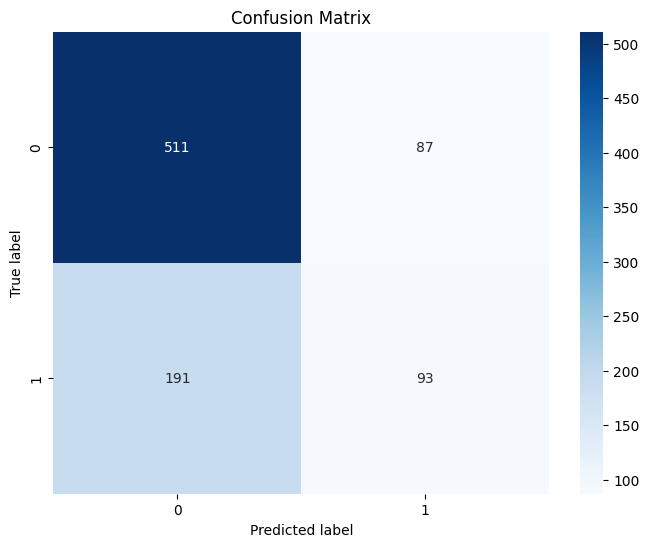

In [ ]:
y_pred = (final_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
labels = [0, 1]
plot_confusion_matrix(y_test, y_pred, labels=labels, normalize=False, title='Confusion Matrix')

### **Model Interpretability**

In [28]:
def plot_feature_importance(model, max_num_features=20):
    # Get the booster from the trained LGBMClassifier
    booster = model.booster_

    # Get feature importances
    importance = booster.feature_importance(importance_type='gain')
    feature_names = booster.feature_name()
    feature_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(max_num_features))
    plt.title('Feature Importance')
    plt.show()

    return feature_importances

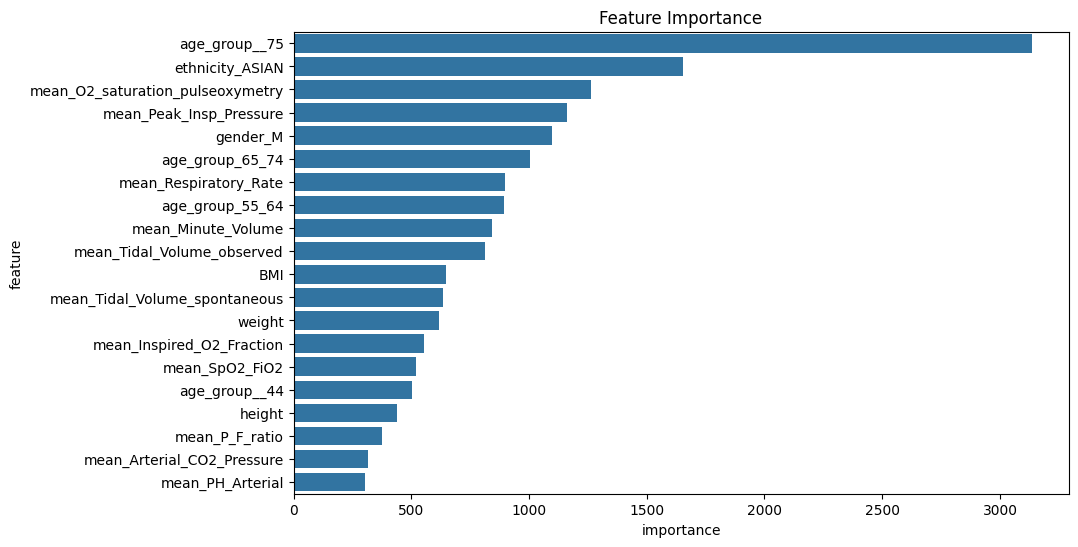

In [ ]:
feature_importances = plot_feature_importance(final_model)

In [ ]:
feature_importances

feature   importance
18                     age_group__75  3134.405977
20                   ethnicity_ASIAN  1652.392427
4   mean_O2_saturation_pulseoxymetry  1264.866442
6            mean_Peak_Insp_Pressure  1162.342836
19                          gender_M  1097.914179
16                   age_group_65_74  1006.138353
7              mean_Respiratory_Rate   898.671678
15                   age_group_55_64   894.281351
3                 mean_Minute_Volume   840.811190
8         mean_Tidal_Volume_observed   813.642488
14                               BMI   645.703203
9      mean_Tidal_Volume_spontaneous   632.796369
12                            weight   617.444118
2          mean_Inspired_O2_Fraction   553.595589
10                    mean_SpO2_FiO2   518.179269
17                     age_group__44   502.399351
13                            height   437.949424
11                    mean_P_F_ratio   375.969307
0         mean_Arterial_CO2_Pressure   315.724525
5                   mean_PH_Arterial   302.123326
1          mean_Arterial_O2_pressure   271.153358
21                   ethnicity_BLACK     9.430930
22                ethnicity_HISPANIC     1.646420
23                   ethnicity_OTHER     0.000000
24                   ethnicity_WHITE     0.000000

The score 0 indicates that several features may be redundant or irrelevant.

LightGBM has built-in mechanisms for feature selection. During the training process, it can decide to ignore certain features if they do not improve the model's performance.

**Feature ablation**

In [29]:
def feature_ablation(model, X_train, y_train, X_test, y_test, params, num_boost_round=100):
    # Function to train and evaluate the model
    def train_and_evaluate(X_train, y_train, X_test, y_test):
        train_data = lgb.Dataset(X_train, label=y_train)
        model = lgb.train(params, train_data, num_boost_round=num_boost_round)
        y_pred = model.predict(X_test)
        y_pred_binary = (y_pred >= 0.5).astype(int)

        accuracy = accuracy_score(y_test, y_pred_binary)
        roc_auc = roc_auc_score(y_test, y_pred)
        return accuracy, roc_auc

    # Baseline model with all features
    baseline_accuracy, baseline_roc_auc = train_and_evaluate(X_train, y_train, X_test, y_test)

    # Store results
    results = []

    # Perform feature ablation
    for feature in X_train.columns:
        X_train_ablate = X_train.drop(columns=[feature])
        X_test_ablate = X_test.drop(columns=[feature])

        accuracy, roc_auc = train_and_evaluate(X_train_ablate, y_train, X_test_ablate, y_test)

        results.append({
            'feature': feature,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'accuracy_drop': baseline_accuracy - accuracy,
            'roc_auc_drop': baseline_roc_auc - roc_auc
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Plot the results
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    sns.barplot(x='accuracy_drop', y='feature', data=results_df.sort_values(by='accuracy_drop', ascending=False), ax=axes[0])
    axes[0].set_title('Drop in Accuracy After Feature Ablation')
    axes[0].set_xlabel('Drop in Accuracy')

    sns.barplot(x='roc_auc_drop', y='feature', data=results_df.sort_values(by='roc_auc_drop', ascending=False), ax=axes[1])
    axes[1].set_title('Drop in ROC AUC After Feature Ablation')
    axes[1].set_xlabel('Drop in ROC AUC')

    plt.tight_layout()
    plt.show()

    return results_df

[LightGBM] [Warning] Unknown parameter: sampling_method
[LightGBM] [Warning] Unknown parameter: sampling_method
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5205
[LightGBM] [Info] Number of data points in the train set: 4692, number of used features: 25
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: sampling_method
[LightGBM] [Warning] Unknown parameter: sampling_method
[LightGBM] [Info] Auto-choosing row-wise multi-threading, th

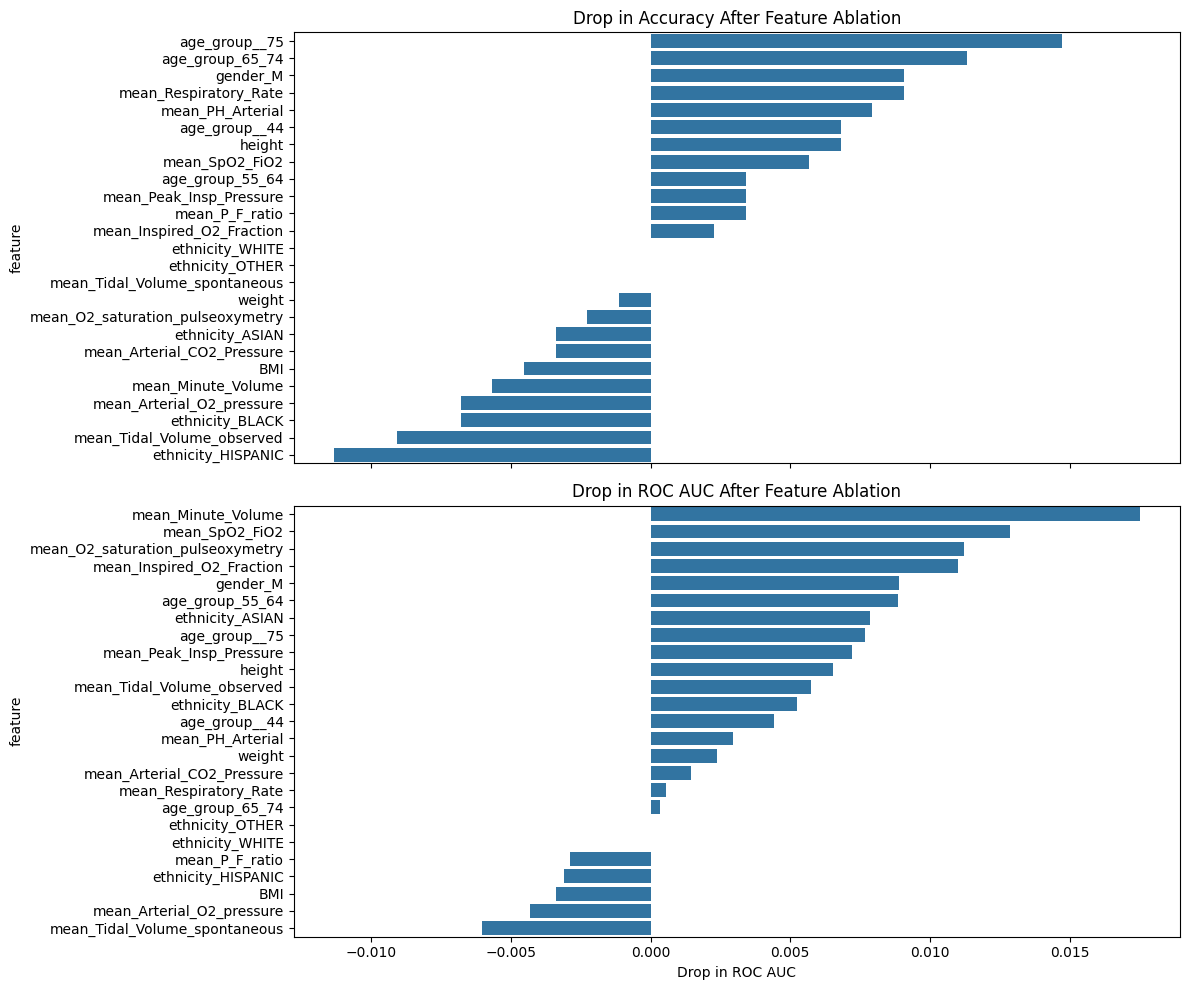

In [ ]:
results_df = feature_ablation(final_model, X_resampled, y_resampled, X_test, y_test, best_params)

In [ ]:
results_df

feature  accuracy   roc_auc  accuracy_drop  \
0         mean_Arterial_CO2_Pressure  0.690476  0.659393      -0.003401   
1          mean_Arterial_O2_pressure  0.693878  0.665169      -0.006803   
2          mean_Inspired_O2_Fraction  0.684807  0.649848       0.002268   
3                 mean_Minute_Volume  0.692744  0.643330      -0.005669   
4   mean_O2_saturation_pulseoxymetry  0.689342  0.649630      -0.002268   
5                   mean_PH_Arterial  0.679138  0.657880       0.007937   
6            mean_Peak_Insp_Pressure  0.683673  0.653646       0.003401   
7              mean_Respiratory_Rate  0.678005  0.660305       0.009070   
8         mean_Tidal_Volume_observed  0.696145  0.655083      -0.009070   
9      mean_Tidal_Volume_spontaneous  0.687075  0.666883       0.000000   
10                    mean_SpO2_FiO2  0.681406  0.647987       0.005669   
11                    mean_P_F_ratio  0.683673  0.663721       0.003401   
12                            weight  0.688209  0.658451      -0.001134   
13                            height  0.680272  0.654317       0.006803   
14                               BMI  0.691610  0.664221      -0.004535   
15                   age_group_55_64  0.683673  0.651968       0.003401   
16                   age_group_65_74  0.675737  0.660512       0.011338   
17                     age_group__44  0.680272  0.656431       0.006803   
18                     age_group__75  0.672336  0.653181       0.014739   
19                          gender_M  0.678005  0.651962       0.009070   
20                   ethnicity_ASIAN  0.690476  0.652969      -0.003401   
21                   ethnicity_BLACK  0.693878  0.655607      -0.006803   
22                ethnicity_HISPANIC  0.698413  0.663933      -0.011338   
23                   ethnicity_OTHER  0.687075  0.660841       0.000000   
24                   ethnicity_WHITE  0.687075  0.660841       0.000000   

    roc_auc_drop  
0       0.001448  
1      -0.004328  
2       0.010993  
3       0.017511  
4       0.011211  
5       0.002962  
6       0.007195  
7       0.000536  
8       0.005759  
9      -0.006041  
10      0.012854  
11     -0.002879  
12      0.002391  
13      0.006524  
14     -0.003380  
15      0.008873  
16      0.000330  
17      0.004410  
18      0.007661  
19      0.008879  
20      0.007872  
21      0.005235  
22     -0.003091  
23      0.000000  
24      0.000000

As per the previous study there are clearly a lot of irrelevent or redundant features.

Let's only plot where the value is not 0 to see the most important features.

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_non_zero_drops(df):
    # Filter the DataFrame to include only rows where accuracy_drop or roc_auc_drop is not zero
    non_zero_drops = df[(df['accuracy_drop'] != 0) | (df['roc_auc_drop'] != 0)]

    # Plot the accuracy drop
    plt.figure(figsize=(14, 7))
    sns.barplot(x='accuracy_drop', y='feature', data=non_zero_drops.sort_values(by='accuracy_drop', ascending=False))
    plt.title('Accuracy Drop After Feature Ablation')
    plt.xlabel('Accuracy Drop')
    plt.ylabel('Feature')
    plt.show()

    # Plot the ROC AUC drop
    plt.figure(figsize=(14, 7))
    sns.barplot(x='roc_auc_drop', y='feature', data=non_zero_drops.sort_values(by='roc_auc_drop', ascending=False))
    plt.title('ROC AUC Drop After Feature Ablation')
    plt.xlabel('ROC AUC Drop')
    plt.ylabel('Feature')
    plt.show()


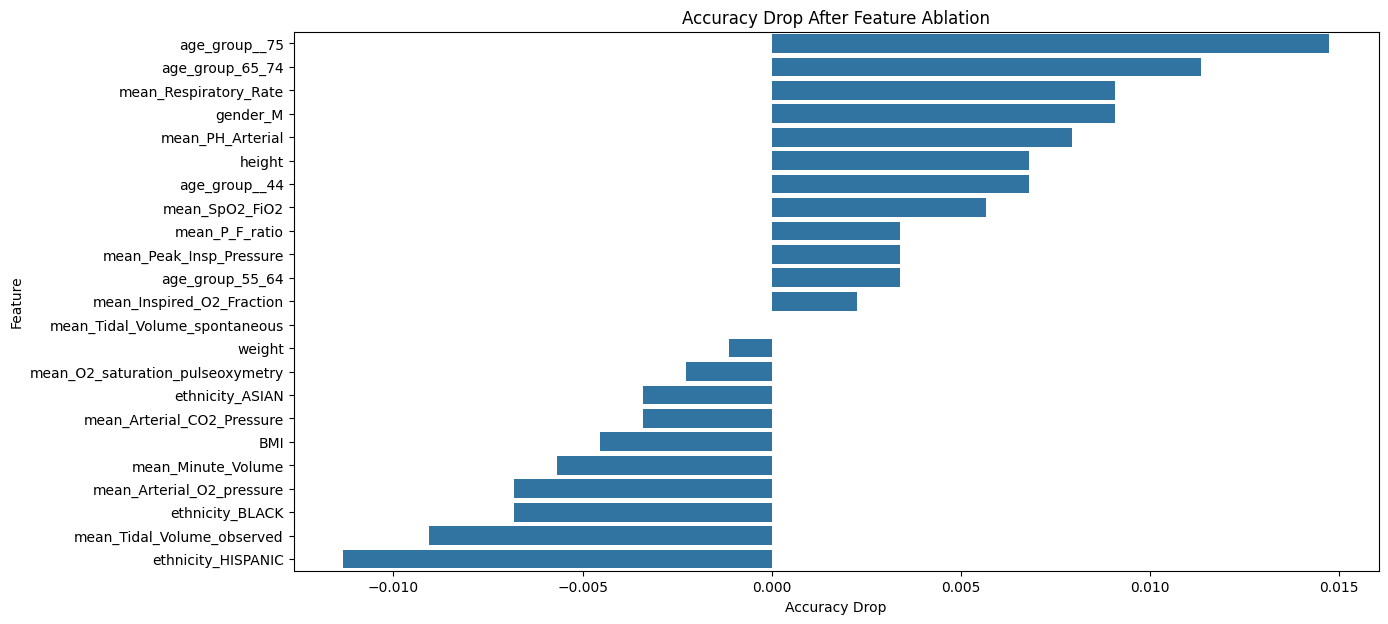

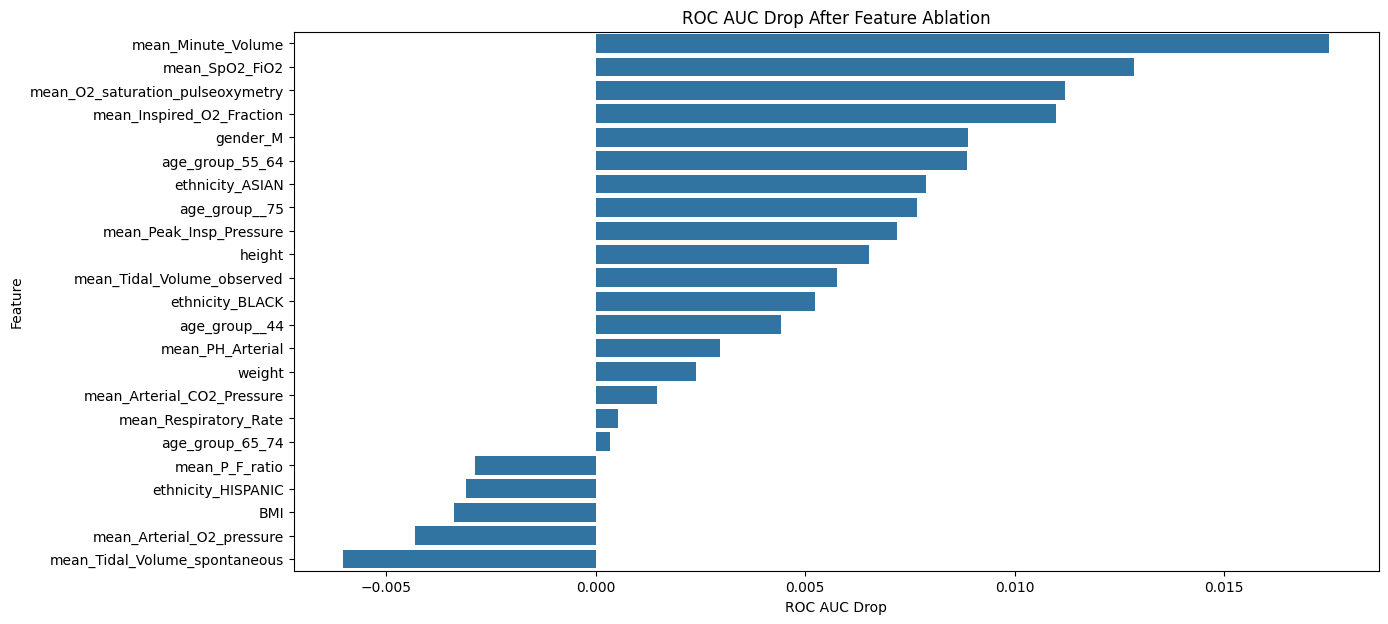

In [ ]:
plot_non_zero_drops(results_df)

This seems to match the LGBM feature importance chart.

**SHAP**

In [ ]:
!pip install shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


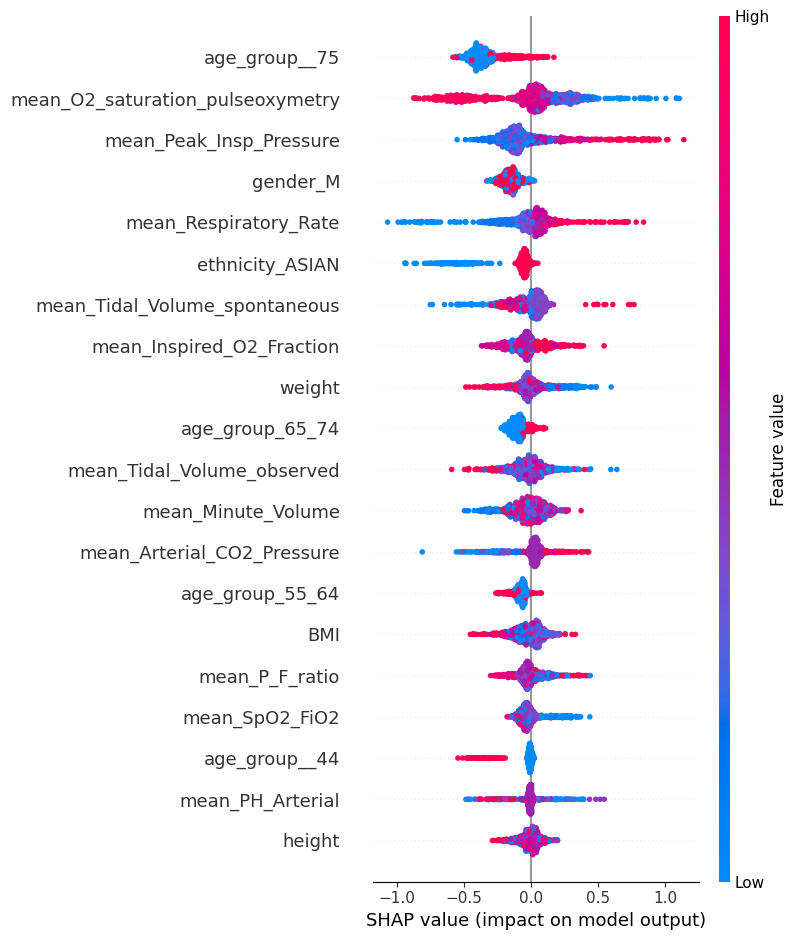

In [ ]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

# Plot summary plot
shap.initjs()
shap.summary_plot(shap_values, X_test)

Also aligns with the previous feature importances.

**Results analysis**

In [31]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001


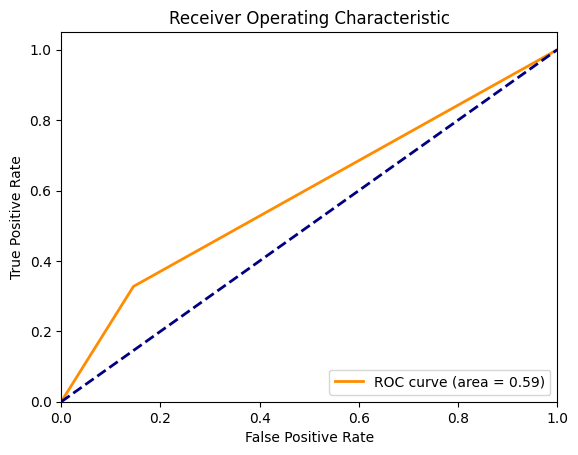

In [ ]:
y_pred_proba = final_model.predict(X_test)
plot_roc_curve(y_test, y_pred_proba)

In [32]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

    plt.figure()
    plt.plot(recall, precision, color='b', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# Plot Precision-Recall curve
plot_precision_recall_curve(y_test, y_pred_proba)

NameError: name 'y_pred_proba' is not defined

In [63]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# Function to plot a single tree with high-quality settings
def plot_single_tree_high_quality(model, tree_index, figsize=(20, 10), dpi=300):
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    lgb.plot_tree(model, tree_index=tree_index, show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'], ax=ax)
    plt.show()

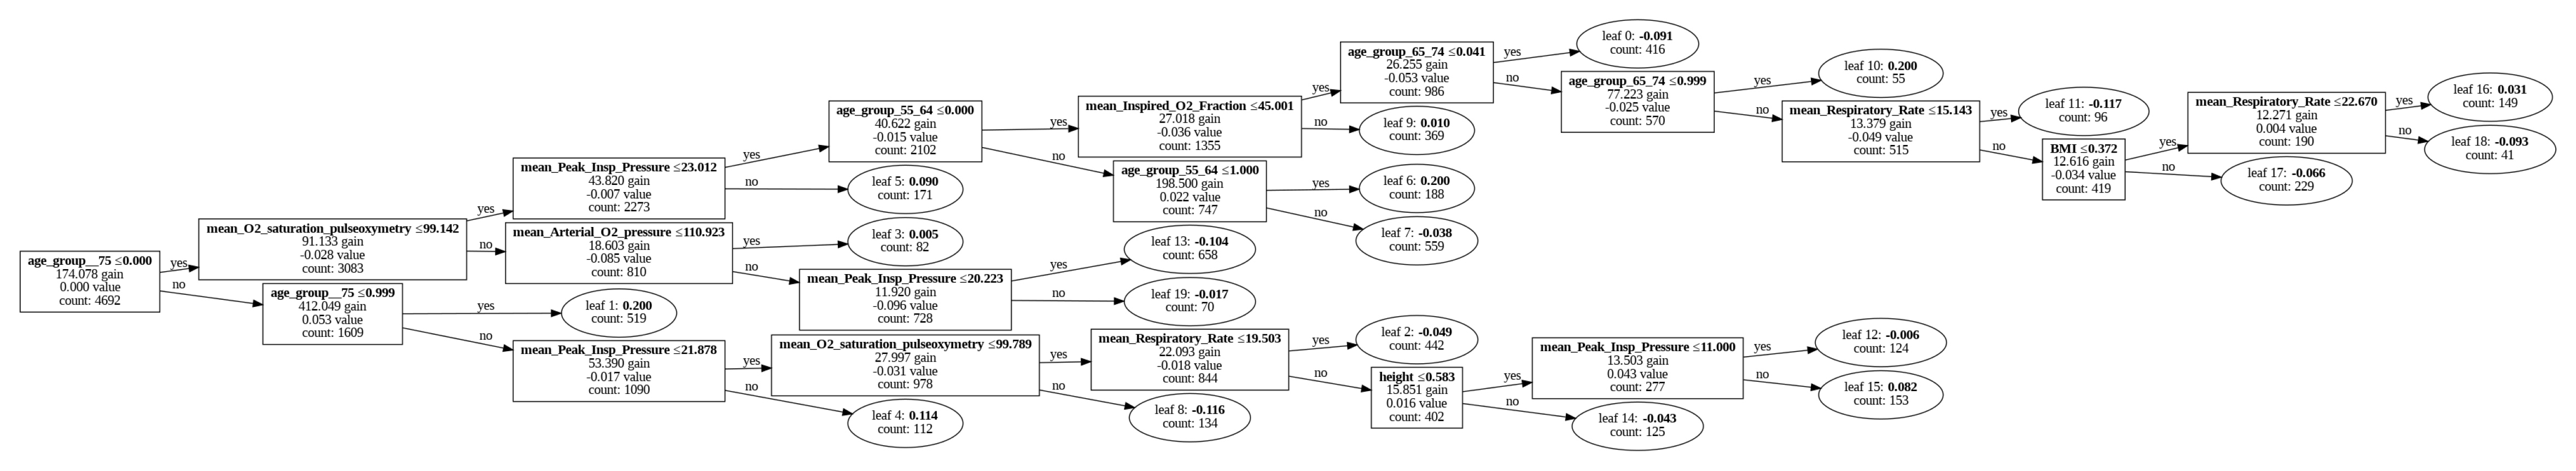

In [ ]:
plot_single_tree_high_quality(final_model, 0)

# **IGNORE THIS^**

# **Experiment 2**

We will now run with lower dimensionality static data to try and make features more meaningful.

In [19]:
# Give an extensive grid of hyperparameter ranges
param_grid = {
    'num_leaves': [20, 30, 40, 50, 60, 70, 80, 90, 100], # Number of leaves in each tree
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], # Maximum depth of the tree
    'min_data_in_leaf': [20, 30, 40, 50, 60, 70, 80, 90, 100], # Minimum number of data in a leaf
    'learning_rate': [0.0001, 0.001, 0.01, 0.1], # Learning rate
    'sampling_method': ['normal', 'undersample', 'oversample'], # Sampling method
    'lambda_l2': [0.0001, 0.001, 0.01, 0.1] # L2 regularization term
}

In [33]:
# Run Bayesian Optimisation
study_2 = optuna.create_study(direction='minimize')
objective = objective_wrapper((X_train, y_train), param_grid)
study_2.optimize(objective, n_trials=100)

best_params = study_2.best_params
print("Best hyperparameters:", best_params)
best_score = study_2.best_value
print("Best score:", best_score)

# Save the best params
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/03_lgbm_model/static_and_dynamic_data/best_models/experiment_2/best_params_v2.json'
with open(params_path, 'w') as f:
    json.dump(best_params, f)

[I 2024-08-07 16:10:46,022] A new study created in memory with name: no-name-a3d89d2e-8875-4a6a-ba5f-203b2faa241e


[LightGBM] [Info] Number of positive: 988, number of negative: 2020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2754
[LightGBM] [Info] Number of data points in the train set: 3008, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 2020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2754
[LightGBM] [Info] Number of data points in the train set: 3008, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 2020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=t

[I 2024-08-07 16:10:47,014] Trial 0 finished with value: 0.636827674670301 and parameters: {'num_leaves': 100, 'max_depth': 3, 'learning_rate': 0.01, 'min_data_in_leaf': 50, 'lambda_l2': 0.0001, 'sampling_method': 'normal'}. Best is trial 0 with value: 0.636827674670301.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:10:48,080] Trial 1 finished with value: 0.6305594256585094 and parameters: {'num_leaves': 80, 'max_depth': 7, 'learning_rate': 0.01, 'min_data_in_leaf': 20, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 1 with value: 0.6305594256585094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-07 16:10:48,481] Trial 2 finished with value: 0.6534813805267167 and parameters: {'num_leaves': 40, 'max_depth': 7, 'learning_rate': 0.1, 'min_data_in_leaf': 90, 'lambda_l2': 0.1, 'sampling_method': 'normal'}. Best is trial 1 with value: 0.6305594256585094.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:10:49,617] Trial 3 finished with value: 0.7917145377904127 and parameters: {'num_leaves': 20, 'max_depth': 5, 'learning_rate': 0.01, 'min_data_in_leaf': 90, 'lambda_l2': 0.01, 'sampling_method': 'oversample'}. Best is trial 1 with value: 0.6305594256585094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	cv_agg's valid auc: 0.791715 + 0.00659805
[LightGBM] [Info] Number of positive: 2020, number of negative: 2020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222
[LightGBM] [Info] Number of data points in the train set: 4040, number of used features: 25
[LightGBM] [Info] Number of positive: 2020, number of negative: 2020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

[I 2024-08-07 16:10:50,504] Trial 4 finished with value: 0.815282815410254 and parameters: {'num_leaves': 50, 'max_depth': 4, 'learning_rate': 0.1, 'min_data_in_leaf': 40, 'lambda_l2': 0.001, 'sampling_method': 'oversample'}. Best is trial 1 with value: 0.6305594256585094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-07 16:10:50,812] Trial 5 finished with value: 0.6435837335475094 and parameters: {'num_leaves': 30, 'max_depth': 5, 'learning_rate': 0.1, 'min_data_in_leaf': 100, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 1 with value: 0.6305594256585094.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:10:50,956] Trial 6 finished with value: 0.6022472094281172 and parameters: {'num_leaves': 100, 'max_depth': 6, 'learning_rate': 0.0001, 'min_data_in_leaf': 40, 'lambda_l2': 0.01, 'sampling_method': 'undersample'}. Best is trial 6 with value: 0.6022472094281172.


[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2581
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2581
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhea

[I 2024-08-07 16:10:51,082] Trial 7 finished with value: 0.6067727712304742 and parameters: {'num_leaves': 50, 'max_depth': 6, 'learning_rate': 0.0001, 'min_data_in_leaf': 100, 'lambda_l2': 0.001, 'sampling_method': 'undersample'}. Best is trial 6 with value: 0.6022472094281172.
[I 2024-08-07 16:10:51,221] Trial 8 finished with value: 0.5987460866429543 and parameters: {'num_leaves': 80, 'max_depth': 10, 'learning_rate': 0.0001, 'min_data_in_leaf': 70, 'lambda_l2': 0.01, 'sampling_method': 'undersample'}. Best is trial 8 with value: 0.5987460866429543.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:10:51,487] Trial 9 finished with value: 0.5932764018423511 and parameters: {'num_leaves': 90, 'max_depth': 9, 'learning_rate': 0.0001, 'min_data_in_leaf': 20, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 9 with value: 0.5932764018423511.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[4]	cv_agg's valid auc: 0.593276 + 0.0152837
[LightGBM] [Info] Number of positive: 988, number of negative: 2020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000769 second

[I 2024-08-07 16:10:51,863] Trial 10 finished with value: 0.6218342886920272 and parameters: {'num_leaves': 90, 'max_depth': 9, 'learning_rate': 0.001, 'min_data_in_leaf': 60, 'lambda_l2': 0.0001, 'sampling_method': 'normal'}. Best is trial 9 with value: 0.5932764018423511.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-07 16:10:52,037] Trial 11 finished with value: 0.6139405661459785 and parameters: {'num_leaves': 90, 'max_depth': 10, 'learning_rate': 0.0001, 'min_data_in_leaf': 70, 'lambda_l2': 0.01, 'sampling_method': 'undersample'}. Best is trial 9 with value: 0.5932764018423511.


[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 23
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 23
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of

[I 2024-08-07 16:10:52,260] Trial 12 finished with value: 0.5979035879952139 and parameters: {'num_leaves': 80, 'max_depth': 9, 'learning_rate': 0.0001, 'min_data_in_leaf': 20, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 9 with value: 0.5932764018423511.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2024-08-07 16:10:52,464] Trial 13 finished with value: 0.5977003392942025 and parameters: {'num_leaves': 70, 'max_depth': 9, 'learning_rate': 0.0001, 'min_data_in_leaf': 20, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 9 with value: 0.5932764018423511.



[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2586
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 25
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2586
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gai

[I 2024-08-07 16:10:52,710] Trial 14 finished with value: 0.6022619613499647 and parameters: {'num_leaves': 70, 'max_depth': 9, 'learning_rate': 0.001, 'min_data_in_leaf': 20, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 9 with value: 0.5932764018423511.



[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2583
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] 

[I 2024-08-07 16:10:53,479] Trial 15 finished with value: 0.7332963434957358 and parameters: {'num_leaves': 70, 'max_depth': 9, 'learning_rate': 0.0001, 'min_data_in_leaf': 80, 'lambda_l2': 0.1, 'sampling_method': 'oversample'}. Best is trial 9 with value: 0.5932764018423511.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-07 16:10:53,648] Trial 16 finished with value: 0.5967381861692537 and parameters: {'num_leaves': 60, 'max_depth': 8, 'learning_rate': 0.0001, 'min_data_in_leaf': 30, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 9 with value: 0.5932764018423511.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-07 16:10:53,852] Trial 17 finished with value: 0.6082397679030962 and parameters: {'num_leaves': 60, 'max_depth': 8, 'learning_rate': 0.0001, 'min_data_in_leaf': 30, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 9 with value: 0.5932764018423511.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-07 16:10:55,053] Trial 18 finished with value: 0.6284491121176895 and parameters: {'num_leaves': 60, 'max_depth': 8, 'learning_rate': 0.001, 'min_data_in_leaf': 30, 'lambda_l2': 0.001, 'sampling_method': 'normal'}. Best is trial 9 with value: 0.5932764018423511.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-07 16:10:55,419] Trial 19 finished with value: 0.7384327026762083 and parameters: {'num_leaves': 90, 'max_depth': 8, 'learning_rate': 0.0001, 'min_data_in_leaf': 30, 'lambda_l2': 0.0001, 'sampling_method': 'oversample'}. Best is trial 9 with value: 0.5932764018423511.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-07 16:10:55,523] Trial 20 finished with value: 0.5841089019652839 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 20 with value: 0.5841089019652839.
[I 2024-08-07 16:10:55,644] Trial 21 finished with value: 0.591434050713829 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 20 with value: 0.5841089019652839.


[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2587
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 23
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2587
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 23
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhea

[I 2024-08-07 16:10:55,783] Trial 22 finished with value: 0.5877345965349374 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 20 with value: 0.5841089019652839.
[I 2024-08-07 16:10:55,913] Trial 23 finished with value: 0.5859512530938058 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 20 with value: 0.5841089019652839.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	cv_agg's valid auc: 0.587735 + 0.0215396
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2573
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2573
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negativ

[I 2024-08-07 16:10:56,041] Trial 24 finished with value: 0.6090757101411267 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 20 with value: 0.5841089019652839.
[I 2024-08-07 16:10:56,151] Trial 25 finished with value: 0.588486944549165 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 20 with value: 0.5841089019652839.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

[I 2024-08-07 16:10:58,624] Trial 26 finished with value: 0.6428690848891148 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.1, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 20 with value: 0.5841089019652839.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[52]	cv_agg's valid auc: 0.642869 + 0.0198531
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overh

[I 2024-08-07 16:11:00,632] Trial 27 finished with value: 0.595012211313085 and parameters: {'num_leaves': 30, 'max_depth': 3, 'learning_rate': 0.001, 'min_data_in_leaf': 60, 'lambda_l2': 0.001, 'sampling_method': 'undersample'}. Best is trial 20 with value: 0.5841089019652839.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	cv_agg's valid auc: 0.595012 + 0.018769
[LightGBM] [Info] Number of positive: 988, number of negative: 2020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2754
[LightGBM] [Info] Number of data points in the train set: 3008, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 2020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2754
[

[I 2024-08-07 16:11:01,272] Trial 28 finished with value: 0.6345532528961398 and parameters: {'num_leaves': 20, 'max_depth': 3, 'learning_rate': 0.01, 'min_data_in_leaf': 60, 'lambda_l2': 0.0001, 'sampling_method': 'normal'}. Best is trial 20 with value: 0.5841089019652839.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopp

[I 2024-08-07 16:11:02,136] Trial 29 finished with value: 0.7692269385354378 and parameters: {'num_leaves': 40, 'max_depth': 3, 'learning_rate': 0.01, 'min_data_in_leaf': 50, 'lambda_l2': 0.0001, 'sampling_method': 'oversample'}. Best is trial 20 with value: 0.5841089019652839.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-07 16:11:02,265] Trial 30 finished with value: 0.6054331182106065 and parameters: {'num_leaves': 100, 'max_depth': 4, 'learning_rate': 0.0001, 'min_data_in_leaf': 80, 'lambda_l2': 0.1, 'sampling_method': 'normal'}. Best is trial 20 with value: 0.5841089019652839.
[I 2024-08-07 16:11:02,402] Trial 31 finished with value: 0.6046206297431527 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 20 with value: 0.5841089019652839.
[I 2024-08-07 16:11:02,510] Trial 32 finished with value: 0.5934960415676376 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 20 with value: 0.5841089019652839.


[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2648
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2648
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhea

[I 2024-08-07 16:11:02,632] Trial 33 finished with value: 0.6122195085970923 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 20 with value: 0.5841089019652839.


[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2584
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2584
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2584
[LightGBM] [Info] Number of

[I 2024-08-07 16:11:03,492] Trial 34 finished with value: 0.6369486469209461 and parameters: {'num_leaves': 60, 'max_depth': 7, 'learning_rate': 0.01, 'min_data_in_leaf': 50, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 20 with value: 0.5841089019652839.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:11:03,622] Trial 35 finished with value: 0.5781392909242898 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-07 16:11:03,990] Trial 36 finished with value: 0.6297497090593192 and parameters: {'num_leaves': 40, 'max_depth': 5, 'learning_rate': 0.1, 'min_data_in_leaf': 90, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[43]	cv_agg's valid auc: 0.62975 + 0.0242866
[LightGBM] [Info] Number of positive: 2020, number of negative: 2020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5227
[LightGBM] [Info] Number of data points in the train set: 4040, number of used features: 24
[LightGBM] [Info] Number of positive: 2020, number of negative: 2020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5227
[LightGBM] [Info] Number of data points in the train set: 4040, number o

[I 2024-08-07 16:11:04,209] Trial 37 finished with value: 0.6753781001862562 and parameters: {'num_leaves': 20, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.01, 'sampling_method': 'oversample'}. Best is trial 35 with value: 0.5781392909242898.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-07 16:11:04,625] Trial 38 finished with value: 0.6429772656493304 and parameters: {'num_leaves': 50, 'max_depth': 7, 'learning_rate': 0.1, 'min_data_in_leaf': 40, 'lambda_l2': 0.001, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best ite

[I 2024-08-07 16:11:05,337] Trial 39 finished with value: 0.6389577905158936 and parameters: {'num_leaves': 30, 'max_depth': 4, 'learning_rate': 0.01, 'min_data_in_leaf': 100, 'lambda_l2': 0.1, 'sampling_method': 'normal'}. Best is trial 35 with value: 0.5781392909242898.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-07 16:11:05,484] Trial 40 finished with value: 0.6030831516661477 and parameters: {'num_leaves': 60, 'max_depth': 6, 'learning_rate': 0.0001, 'min_data_in_leaf': 90, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2570
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warn

[I 2024-08-07 16:11:05,601] Trial 41 finished with value: 0.6087741152944648 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.
[I 2024-08-07 16:11:05,722] Trial 42 finished with value: 0.5884148240423543 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	cv_agg's valid auc: 0.608774 + 0.0201753
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2590
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2590
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

[I 2024-08-07 16:11:05,865] Trial 43 finished with value: 0.5929846416102542 and parameters: {'num_leaves': 100, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:11:06,066] Trial 44 finished with value: 0.6035830779065383 and parameters: {'num_leaves': 60, 'max_depth': 10, 'learning_rate': 0.0001, 'min_data_in_leaf': 70, 'lambda_l2': 0.01, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:11:06,270] Trial 45 finished with value: 0.5983264764215116 and parameters: {'num_leaves': 80, 'max_depth': 5, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-07 16:11:06,491] Trial 46 finished with value: 0.5960743496861118 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 40, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.
[I 2024-08-07 16:11:06,604] Trial 47 finished with value: 0.6036240554672261 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.001, 'min_data_in_leaf': 60, 'lambda_l2': 0.0001, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:11:06,840] Trial 48 finished with value: 0.7207297323791785 and parameters: {'num_leaves': 60, 'max_depth': 6, 'learning_rate': 0.0001, 'min_data_in_leaf': 80, 'lambda_l2': 0.1, 'sampling_method': 'oversample'}. Best is trial 35 with value: 0.5781392909242898.


[LightGBM] [Info] Number of positive: 2020, number of negative: 2020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5215
[LightGBM] [Info] Number of data points in the train set: 4040, number of used features: 24
[LightGBM] [Info] Number of positive: 2020, number of negative: 2020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5215
[LightGBM] [Info] Number of data points in the train set: 4040, number of used features: 24
[LightGBM] [Info] Number of positive: 2020, number of negative: 2020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_col_wise=true` to remove the o

[I 2024-08-07 16:11:06,975] Trial 49 finished with value: 0.6107803766657378 and parameters: {'num_leaves': 50, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 100, 'lambda_l2': 0.01, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.


[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2586
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 22
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2586
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 22
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2586
[LightGBM] [Info] Number of

[I 2024-08-07 16:11:07,398] Trial 50 finished with value: 0.6498385484108903 and parameters: {'num_leaves': 40, 'max_depth': 10, 'learning_rate': 0.1, 'min_data_in_leaf': 60, 'lambda_l2': 0.001, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-07 16:11:07,511] Trial 51 finished with value: 0.5929846416102542 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.
[I 2024-08-07 16:11:07,671] Trial 52 finished with value: 0.590499762330148 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.


[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2585
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2585
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhea

[I 2024-08-07 16:11:07,805] Trial 53 finished with value: 0.5860069825763412 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.
[I 2024-08-07 16:11:07,919] Trial 54 finished with value: 0.5833352456194988 and parameters: {'num_leaves': 70, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 70, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:11:08,077] Trial 55 finished with value: 0.606803914176597 and parameters: {'num_leaves': 70, 'max_depth': 7, 'learning_rate': 0.0001, 'min_data_in_leaf': 70, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.



[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2579
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 23
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2579
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 23
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2579
[LightGBM] [Info] Number o

[I 2024-08-07 16:11:08,222] Trial 56 finished with value: 0.5983998075920953 and parameters: {'num_leaves': 70, 'max_depth': 4, 'learning_rate': 0.0001, 'min_data_in_leaf': 70, 'lambda_l2': 0.1, 'sampling_method': 'normal'}. Best is trial 35 with value: 0.5781392909242898.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:11:08,396] Trial 57 finished with value: 0.6125981412578472 and parameters: {'num_leaves': 70, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 70, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.
[I 2024-08-07 16:11:08,521] Trial 58 finished with value: 0.6014325755216444 and parameters: {'num_leaves': 90, 'max_depth': 3, 'learning_rate': 0.001, 'min_data_in_leaf': 20, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:11:08,679] Trial 59 finished with value: 0.6071333737645266 and parameters: {'num_leaves': 80, 'max_depth': 5, 'learning_rate': 0.0001, 'min_data_in_leaf': 70, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.


[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2590
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 23
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2590
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 23
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2590
[LightGBM] [Info] Number of

[I 2024-08-07 16:11:08,872] Trial 60 finished with value: 0.6707691402803646 and parameters: {'num_leaves': 70, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 90, 'lambda_l2': 0.0001, 'sampling_method': 'oversample'}. Best is trial 35 with value: 0.5781392909242898.



[LightGBM] [Info] Number of positive: 2020, number of negative: 2020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5221
[LightGBM] [Info] Number of data points in the train set: 4040, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:

[I 2024-08-07 16:11:09,008] Trial 61 finished with value: 0.5877772131980528 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:11:09,284] Trial 62 finished with value: 0.5839220442885475 and parameters: {'num_leaves': 20, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 50, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:11:09,456] Trial 63 finished with value: 0.5938845088429575 and parameters: {'num_leaves': 20, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 50, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.



[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits wit

[I 2024-08-07 16:11:09,614] Trial 64 finished with value: 0.5900768739038502 and parameters: {'num_leaves': 20, 'max_depth': 8, 'learning_rate': 0.0001, 'min_data_in_leaf': 50, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.
[I 2024-08-07 16:11:09,737] Trial 65 finished with value: 0.6034814535560327 and parameters: {'num_leaves': 20, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 50, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.


Early stopping, best iteration is:
[1]	cv_agg's valid auc: 0.590077 + 0.0243004
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2584
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2584
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to re

[I 2024-08-07 16:11:11,006] Trial 66 finished with value: 0.633880247176646 and parameters: {'num_leaves': 100, 'max_depth': 9, 'learning_rate': 0.01, 'min_data_in_leaf': 50, 'lambda_l2': 0.001, 'sampling_method': 'undersample'}. Best is trial 35 with value: 0.5781392909242898.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-07 16:11:11,519] Trial 67 finished with value: 0.5697831467488403 and parameters: {'num_leaves': 20, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 30, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[2]	cv_agg's valid auc: 0.569783 + 0.0218142
[LightGBM] [Info] Number of positive: 988, number of negative: 2020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2756
[LightGBM] [Info] Number of data points in the train set: 3008, number of used features: 25
[LightGBM] [Info] Number of positive: 9

[I 2024-08-07 16:11:12,159] Trial 68 finished with value: 0.5892876899025936 and parameters: {'num_leaves': 20, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 30, 'lambda_l2': 0.1, 'sampling_method': 'normal'}. Best is trial 67 with value: 0.5697831467488403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	cv_agg's valid auc: 0.589288 + 0.0218149
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2587
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number o

[I 2024-08-07 16:11:15,625] Trial 69 finished with value: 0.5879345670310938 and parameters: {'num_leaves': 20, 'max_depth': 6, 'learning_rate': 0.001, 'min_data_in_leaf': 30, 'lambda_l2': 0.01, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.


Did not meet early stopping. Best iteration is:
[99]	cv_agg's valid auc: 0.587935 + 0.0313663
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2590
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2590
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wi

[I 2024-08-07 16:11:16,021] Trial 70 finished with value: 0.6431133111508138 and parameters: {'num_leaves': 30, 'max_depth': 3, 'learning_rate': 0.1, 'min_data_in_leaf': 30, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:11:16,152] Trial 71 finished with value: 0.5886147945385107 and parameters: {'num_leaves': 20, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 30, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.


[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2599
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2599
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2599
[LightGBM] [Info] Number of

[I 2024-08-07 16:11:16,332] Trial 72 finished with value: 0.6043288695110558 and parameters: {'num_leaves': 20, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 80, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.
[I 2024-08-07 16:11:16,465] Trial 73 finished with value: 0.6002671736956842 and parameters: {'num_leaves': 50, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 40, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:11:16,592] Trial 74 finished with value: 0.6016095985838155 and parameters: {'num_leaves': 90, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.


[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2581
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2581
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2581
[LightGBM] [Info] Number of

[I 2024-08-07 16:11:16,872] Trial 75 finished with value: 0.6248569883131997 and parameters: {'num_leaves': 60, 'max_depth': 10, 'learning_rate': 0.0001, 'min_data_in_leaf': 100, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-07 16:11:17,066] Trial 76 finished with value: 0.651776884619155 and parameters: {'num_leaves': 70, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 20, 'lambda_l2': 0.1, 'sampling_method': 'oversample'}. Best is trial 67 with value: 0.5697831467488403.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5227
[LightGBM] [Info] Number of data points in the train set: 4040, number of used features: 25
[LightGBM] [Info] Number of positive: 2020, number of negative: 2020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5227
[LightGBM] [Info] Number of data points in the train set: 4040, number of used features: 25
[LightGBM] [Info] Number of positive: 2020, number of negative: 2020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5227
[LightGBM] [Info] Number o

[I 2024-08-07 16:11:17,220] Trial 77 finished with value: 0.5921060827091085 and parameters: {'num_leaves': 60, 'max_depth': 4, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.0001, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.


Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2024-08-07 16:11:17,483] Trial 78 finished with value: 0.6218820174072677 and parameters: {'num_leaves': 40, 'max_depth': 7, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:11:18,109] Trial 79 finished with value: 0.629803799439427 and parameters: {'num_leaves': 80, 'max_depth': 3, 'learning_rate': 0.01, 'min_data_in_leaf': 70, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:11:18,565] Trial 80 finished with value: 0.6230143905078767 and parameters: {'num_leaves': 60, 'max_depth': 8, 'learning_rate': 0.0001, 'min_data_in_leaf': 50, 'lambda_l2': 0.001, 'sampling_method': 'normal'}. Best is trial 67 with value: 0.5697831467488403.
[I 2024-08-07 16:11:18,691] Trial 81 finished with value: 0.5971250143421463 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.


[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2634
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2634
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2634
[LightGBM] [Info] Number of

[I 2024-08-07 16:11:18,850] Trial 82 finished with value: 0.6092871543542756 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.
[I 2024-08-07 16:11:18,967] Trial 83 finished with value: 0.58964906817027 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	cv_agg's valid auc: 0.609287 + 0.0129125
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2580
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 23
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2580
[L

[I 2024-08-07 16:11:19,106] Trial 84 finished with value: 0.5824386565916504 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.
[I 2024-08-07 16:11:19,223] Trial 85 finished with value: 0.5907472667967021 and parameters: {'num_leaves': 30, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.


[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2580
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2580
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2580
[LightGBM] [Info] Number of

[I 2024-08-07 16:11:19,643] Trial 86 finished with value: 0.6354964021701717 and parameters: {'num_leaves': 60, 'max_depth': 9, 'learning_rate': 0.1, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:11:19,790] Trial 87 finished with value: 0.5936304479666935 and parameters: {'num_leaves': 100, 'max_depth': 5, 'learning_rate': 0.0001, 'min_data_in_leaf': 90, 'lambda_l2': 0.01, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2587
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 23
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2587
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

[I 2024-08-07 16:11:19,957] Trial 88 finished with value: 0.5974151354718156 and parameters: {'num_leaves': 20, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 30, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.
[I 2024-08-07 16:11:20,076] Trial 89 finished with value: 0.570574833221328 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:11:20,496] Trial 90 finished with value: 0.6811461621409666 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'oversample'}. Best is trial 67 with value: 0.5697831467488403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-07 16:11:20,641] Trial 91 finished with value: 0.5991001327672967 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.


[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2581
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2581
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain

[I 2024-08-07 16:11:21,079] Trial 92 finished with value: 0.6104378042583881 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:11:21,222] Trial 93 finished with value: 0.5989296661148356 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.001, 'min_data_in_leaf': 60, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:11:21,739] Trial 94 finished with value: 0.6308102083299186 and parameters: {'num_leaves': 70, 'max_depth': 6, 'learning_rate': 0.001, 'min_data_in_leaf': 80, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-08-07 16:11:21,919] Trial 95 finished with value: 0.5812371945122851 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.001, 'min_data_in_leaf': 40, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.


[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2599
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2599
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true

[I 2024-08-07 16:11:22,079] Trial 96 finished with value: 0.6142274090707928 and parameters: {'num_leaves': 60, 'max_depth': 3, 'learning_rate': 0.001, 'min_data_in_leaf': 70, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.
[I 2024-08-07 16:11:22,196] Trial 97 finished with value: 0.5830467635922568 and parameters: {'num_leaves': 50, 'max_depth': 3, 'learning_rate': 0.001, 'min_data_in_leaf': 40, 'lambda_l2': 0.0001, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.


[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2570
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:Boo

[I 2024-08-07 16:11:22,485] Trial 98 finished with value: 0.5853365896834892 and parameters: {'num_leaves': 50, 'max_depth': 10, 'learning_rate': 0.001, 'min_data_in_leaf': 40, 'lambda_l2': 0.0001, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[8]	cv_agg's valid auc: 0.585337 + 0.00948354
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2593
[LightGBM] [Info] Number of data points in the train set: 1976, number of used features: 24
[LightGBM] [Info] Number of positive: 988, number of negative: 988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2593
[LightGBM] [Info] Number of data points in the train set: 1976, number of us

[I 2024-08-07 16:11:22,966] Trial 99 finished with value: 0.5825992886295466 and parameters: {'num_leaves': 50, 'max_depth': 10, 'learning_rate': 0.001, 'min_data_in_leaf': 40, 'lambda_l2': 0.0001, 'sampling_method': 'undersample'}. Best is trial 67 with value: 0.5697831467488403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best hyperparameters: {'num_leaves': 20, 'max_depth': 3, 'learning_rate': 0.0001, 'min_data_in_leaf': 30, 'lambda_l2': 0.1, 'sampling_method': 'undersample'}


Best score: 0.5697831467488403


In [34]:
final_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    boosting_type='gbdt',
    num_leaves=best_params['num_leaves'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    min_data_in_leaf=best_params['min_data_in_leaf'],
    lambda_l2=best_params['lambda_l2']
  )

final_model

LGBMClassifier(lambda_l2=0.1, learning_rate=0.0001, max_depth=3, metric='auc',
               min_data_in_leaf=30, num_leaves=20, objective='binary')

In [35]:
# Prepare the data with the best sampling method
if best_params['sampling_method'] == 'undersample':
    X_resampled, y_resampled = undersample_data(X_train, y_train)
elif best_params['sampling_method'] == 'oversample':
    X_resampled, y_resampled = oversample_data(X_train, y_train)
else:
    X_resampled, y_resampled = X_train, y_train

In [36]:
# Train the final model
final_model.fit(X_resampled, y_resampled)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Number of positive: 1235, number of negative: 1235
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2575
[LightGBM] [Info] Number of data points in the train set: 2470, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with posi

LGBMClassifier(lambda_l2=0.1, learning_rate=0.0001, max_depth=3, metric='auc',
               min_data_in_leaf=30, num_leaves=20, objective='binary')

In [37]:
# Save the trained model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/03_lgbm_model/static_and_dynamic_data/best_models/experiment_2/final_model_v2.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(final_model, f)

**Evaluate the final model**

In [ ]:
evaluate_lgbm_model(final_model, X_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
Accuracy: 0.6111
Precision: 0.4160
Recall (Sensitivity): 0.5141
F1 Score: 0.4598
ROC AUC: 0.5856
Specificity: 0.6572


(0.6111111111111112,
 0.41595441595441596,
 0.5140845070422535,
 0.45984251968503936,
 0.5856375712468793,
 0.657190635451505)

Accuracy: 0.6111
Precision: 0.4160
Recall (Sensitivity): 0.5141
F1 Score: 0.4598
ROC AUC: 0.5856
Specificity: 0.6572

**Ensemble method**

In [45]:
_, predictions = evaluate_lgbm_model(final_model, X_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
Accuracy: 0.6174
Precision: 0.4220
Recall (Sensitivity): 0.4466
F1 Score: 0.4340
ROC AUC: 0.5825
Specificity: 0.7009


In [48]:
predictions.shape

(941,)

In [49]:
# Save predictions for ensemble method
np.save('/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/03_lgbm_model/static_and_dynamic_data/best_models/experiment_2/predictions_v2.npy', predictions)

**Confusion matrix**

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


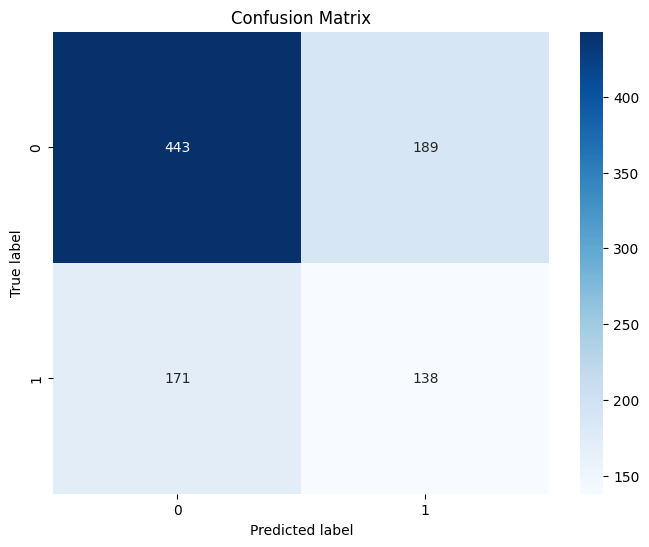

In [50]:
y_pred = (final_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
labels = [0, 1]
plot_confusion_matrix(y_test, y_pred, labels=labels, normalize=False, title='Confusion Matrix')

### **Model Interpretability**

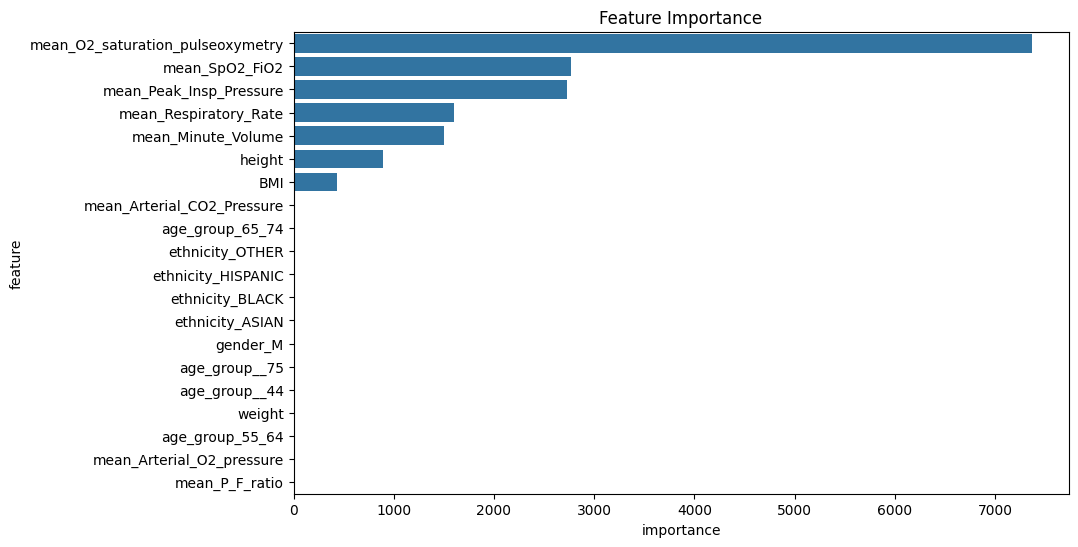

In [51]:
feature_importances = plot_feature_importance(final_model)

In [52]:
feature_importances

feature   importance
4   mean_O2_saturation_pulseoxymetry  7365.482658
10                    mean_SpO2_FiO2  2773.472698
6            mean_Peak_Insp_Pressure  2732.226795
7              mean_Respiratory_Rate  1602.973503
3                 mean_Minute_Volume  1498.874800
13                            height   894.353217
14                               BMI   433.341849
0         mean_Arterial_CO2_Pressure     0.000000
16                   age_group_65_74     0.000000
23                   ethnicity_OTHER     0.000000
22                ethnicity_HISPANIC     0.000000
21                   ethnicity_BLACK     0.000000
20                   ethnicity_ASIAN     0.000000
19                          gender_M     0.000000
18                     age_group__75     0.000000
17                     age_group__44     0.000000
12                            weight     0.000000
15                   age_group_55_64     0.000000
1          mean_Arterial_O2_pressure     0.000000
11                    mean_P_F_ratio     0.000000
9      mean_Tidal_Volume_spontaneous     0.000000
8         mean_Tidal_Volume_observed     0.000000
5                   mean_PH_Arterial     0.000000
2          mean_Inspired_O2_Fraction     0.000000
24                   ethnicity_WHITE     0.000000

**Feature ablation**

[LightGBM] [Warning] Unknown parameter: sampling_method
[LightGBM] [Warning] Unknown parameter: sampling_method
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2575
[LightGBM] [Info] Number of data points in the train set: 2470, number of used features: 24
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

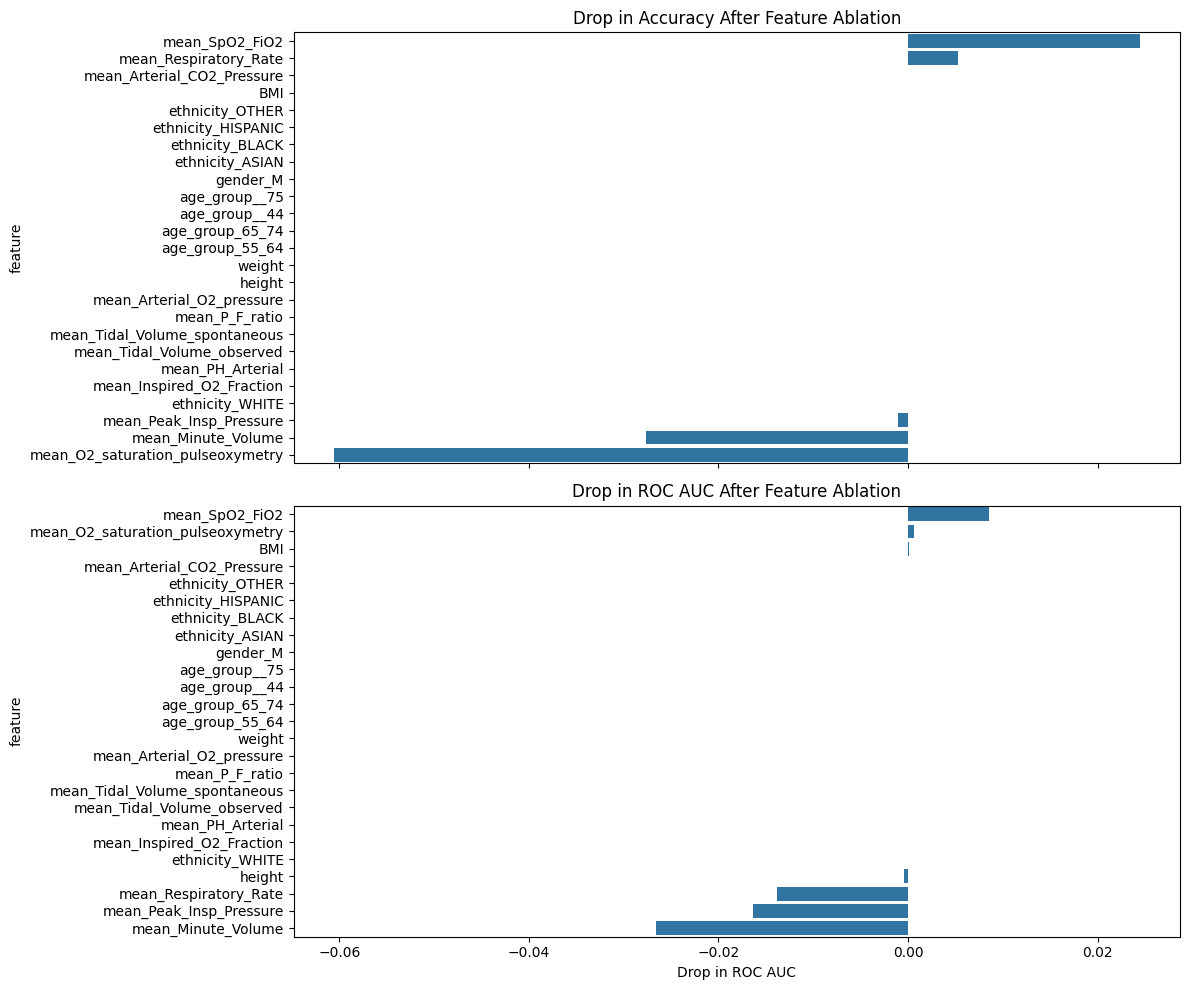

In [53]:
results_df = feature_ablation(final_model, X_resampled, y_resampled, X_test, y_test, best_params)

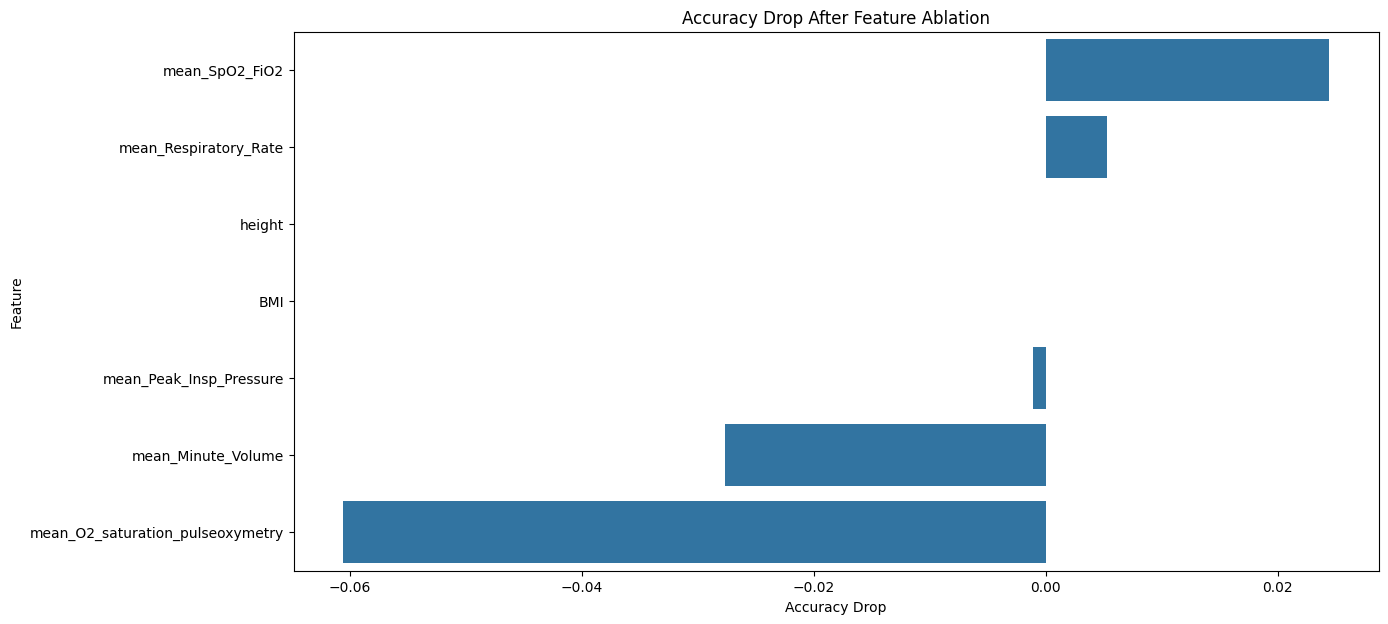

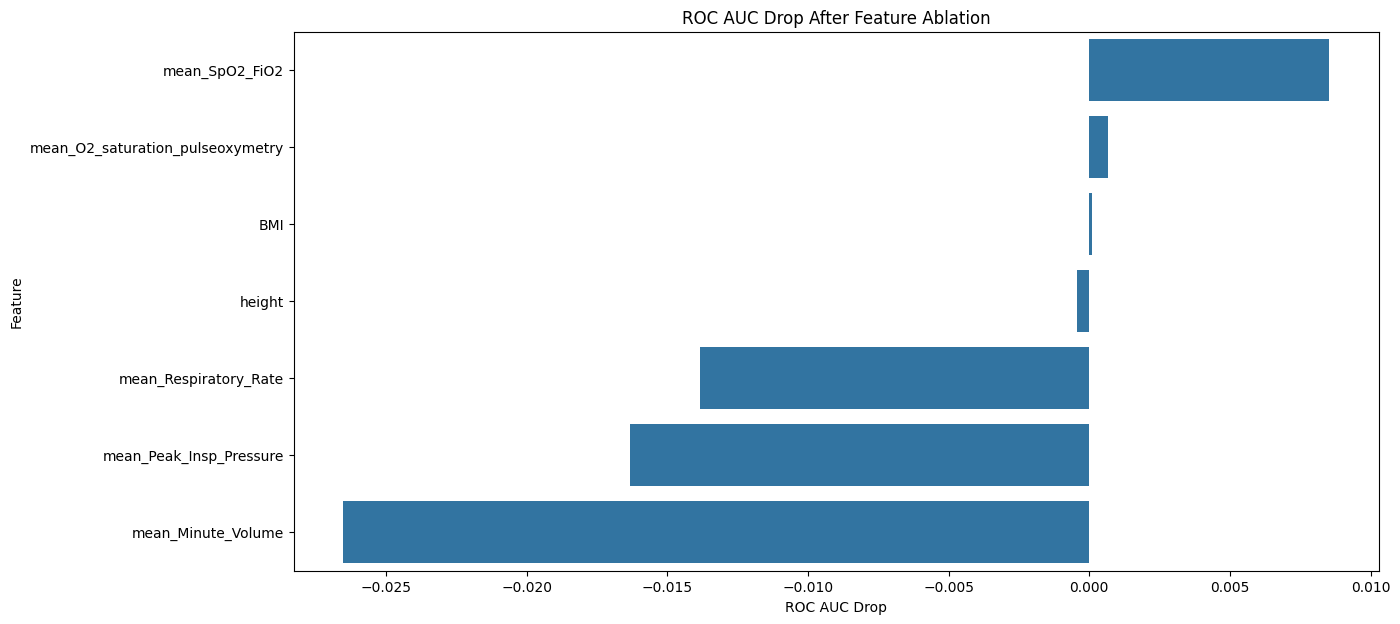

In [54]:
plot_non_zero_drops(results_df)

**SHAP**

In [57]:
!pip install shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 15.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


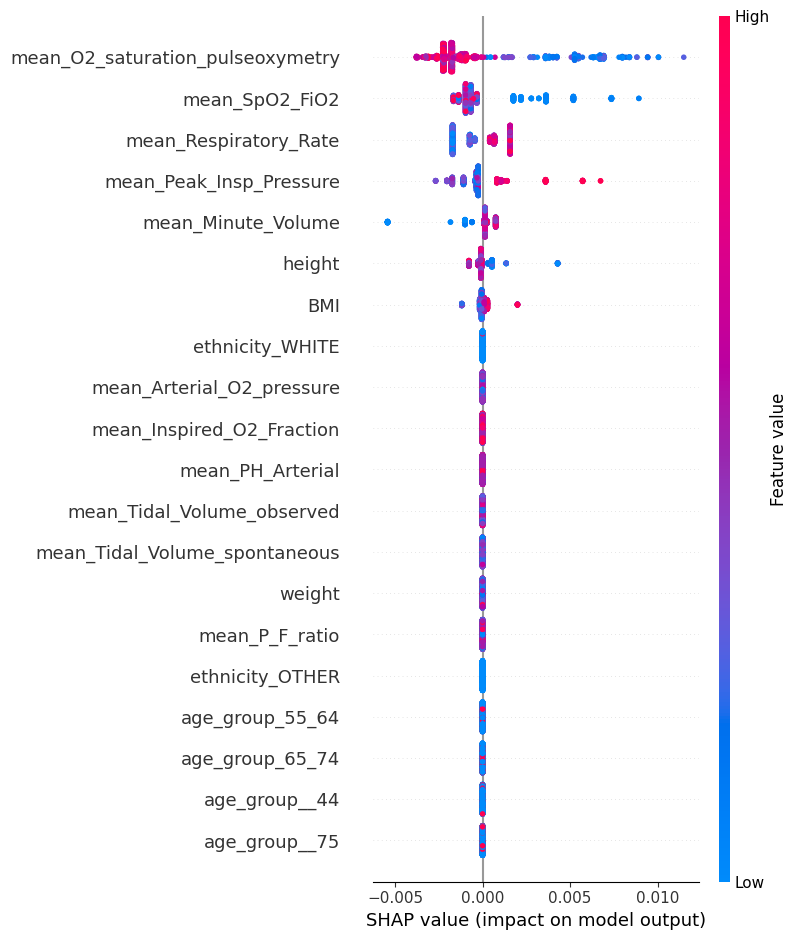

In [58]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

# Plot summary plot
shap.initjs()
shap.summary_plot(shap_values, X_test)

**ROC curve**

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


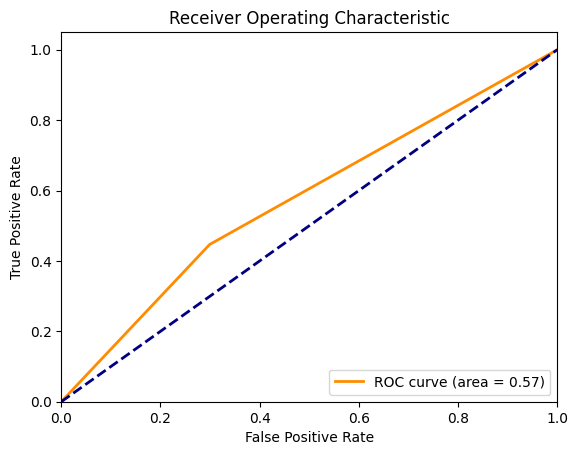

In [59]:
y_pred_proba = final_model.predict(X_test)
plot_roc_curve(y_test, y_pred_proba)

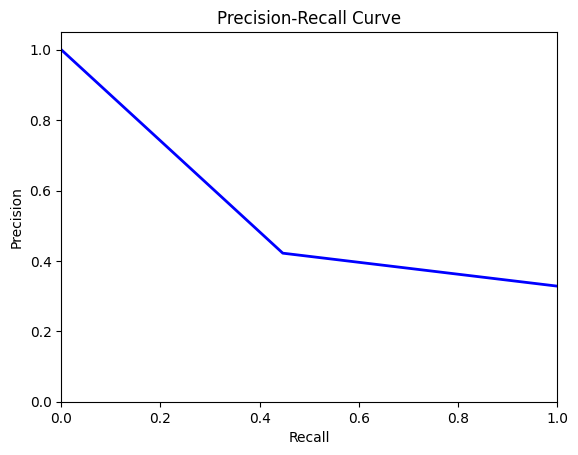

In [60]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

    plt.figure()
    plt.plot(recall, precision, color='b', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# Plot Precision-Recall curve
plot_precision_recall_curve(y_test, y_pred_proba)

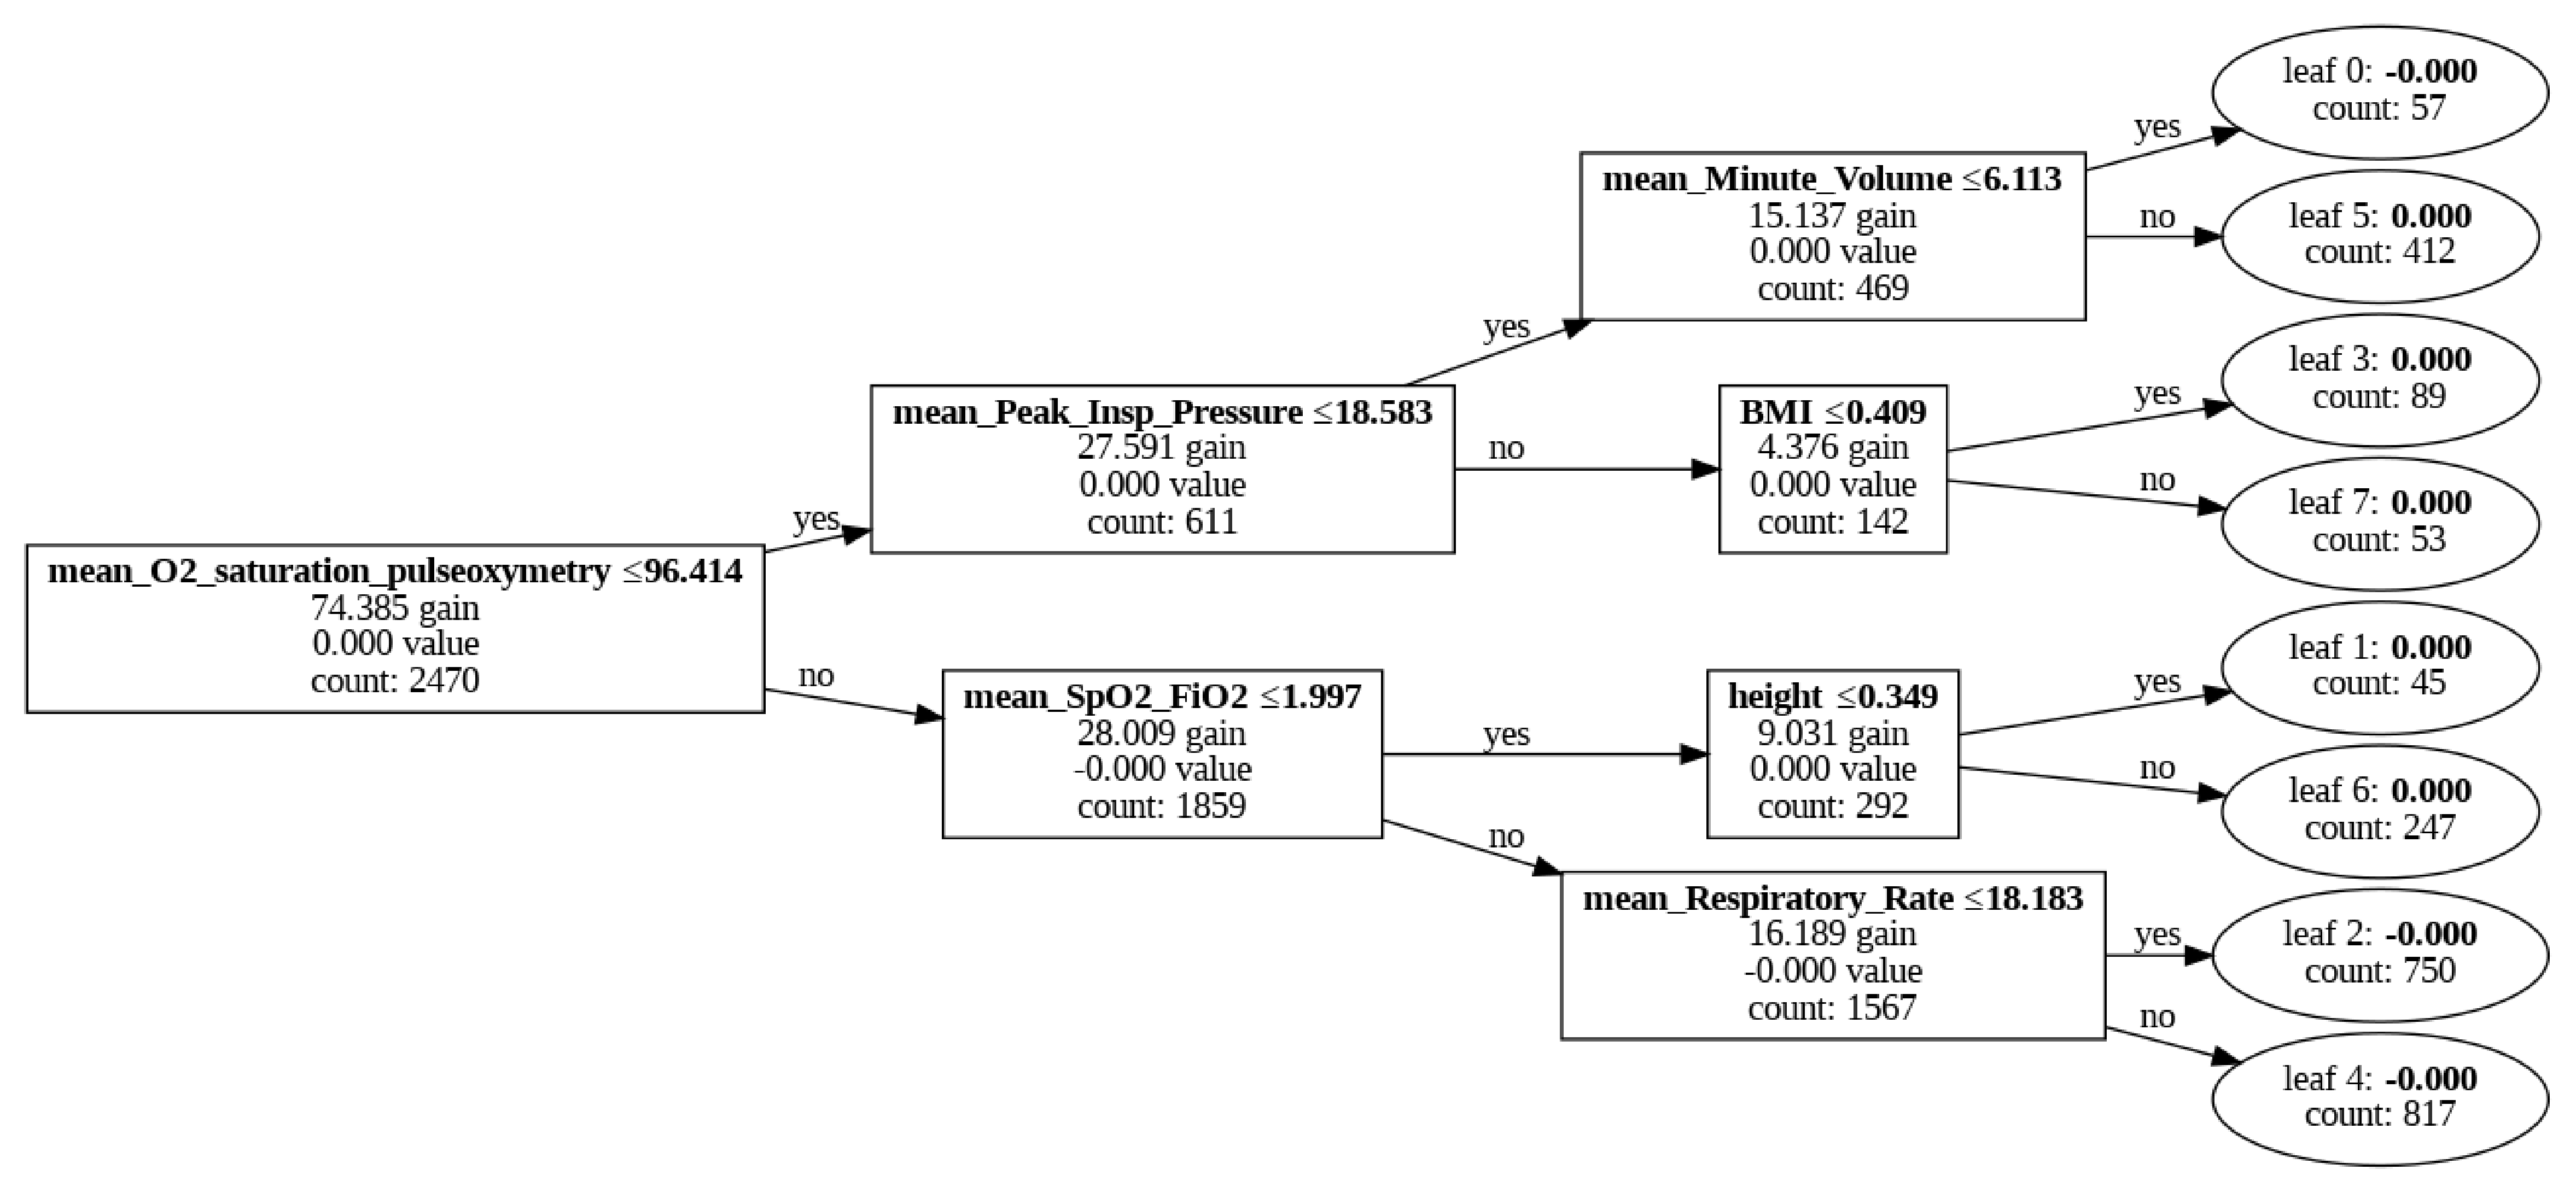

In [64]:
plot_single_tree_high_quality(final_model, tree_index=0, figsize=(20, 10), dpi=300)

**Best threshold analysis**

In [62]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def find_best_threshold_and_evaluate(model, X_test, y_test):
    """
    Find the best threshold for binary classification based on ROC AUC and calculate evaluation metrics.

    Parameters:
    model (LGBMClassifier): The trained LightGBM model.
    X_test (np.array or pd.DataFrame): Test features.
    y_test (np.array or pd.Series): True labels for the test data.

    Returns:
    dict: A dictionary containing the best threshold, ROC AUC, and other evaluation metrics.
    """
    # Get model output (predicted probabilities)
    all_probs = model.predict_proba(X_test)[:, 1]

    # Convert true labels to numpy array
    all_labels = np.array(y_test)

    best_threshold = 0.5
    best_metric_value = 0.0

    thresholds = np.arange(0.0, 1.0, 0.01)  # You can change the step size if needed

    for threshold in thresholds:
        preds = (all_probs >= threshold).astype(int)
        metric_value = roc_auc_score(all_labels, preds)

        if metric_value > best_metric_value:
            best_metric_value = metric_value
            best_threshold = threshold

    # Apply the best threshold to get the final predictions
    final_preds = (all_probs >= best_threshold).astype(int)

    # Calculate the final evaluation metrics
    accuracy = accuracy_score(all_labels, final_preds)
    precision = precision_score(all_labels, final_preds)
    recall = recall_score(all_labels, final_preds)
    f1 = f1_score(all_labels, final_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)  # Use probabilities for ROC AUC
    specificity = recall_score(all_labels, final_preds, pos_label=0)

    metrics = {
        'best_threshold': best_threshold,
        'best_metric_value': best_metric_value,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'specificity': specificity
    }

    print(f"Best Threshold: {best_threshold}")
    print(f"Best Metric Value: {best_metric_value}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Specificity: {specificity:.4f}")

    return metrics

In [65]:
# Find the best threshold
find_best_threshold_and_evaluate(final_model, X_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
Best Threshold: 0.5
Best Metric Value: 0.5737756544180901
Accuracy: 0.6174
Precision: 0.4220
Recall: 0.4466
F1 Score: 0.4340
ROC AUC: 0.5825
Specificity: 0.7009


{'best_threshold': 0.5,
 'best_metric_value': 0.5737756544180901,
 'accuracy': 0.6174282678002125,
 'precision': 0.42201834862385323,
 'recall': 0.44660194174757284,
 'f1_score': 0.4339622641509434,
 'roc_auc': 0.58250890991766,
 'specificity': 0.7009493670886076}

The best threshold is the standard threshold of 0.5.